In [1]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
#https://github.com/scikit-optimize/scikit-optimize/tree/master/examples

In [2]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

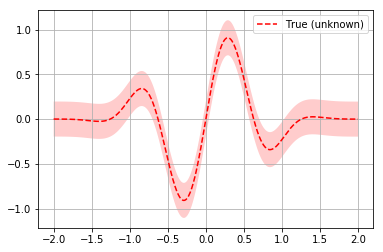

In [3]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [4]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

In [5]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.3143, f(x^*)=-0.8533'

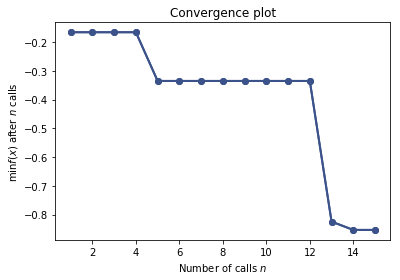

In [7]:
from skopt.plots import plot_convergence
plot_convergence(res);
plt.show()

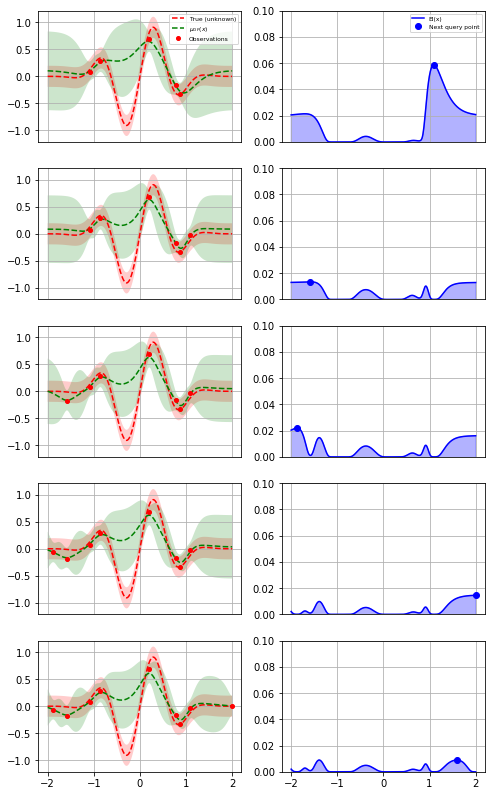

In [8]:
from skopt.acquisition import gaussian_ei

plt.rcParams["figure.figsize"] = (8, 14)

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(5):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:5+n_iter]
    curr_func_vals = res.func_vals[:5+n_iter]

    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5+n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

plt.show()

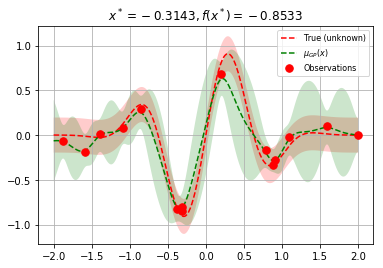

In [9]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = res.models[-1]
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(res.x_iters, 
         res.func_vals, 
         "r.", markersize=15, label="Observations")

plt.title(r"$x^* = %.4f, f(x^*) = %.4f$" % (res.x[0], res.fun))
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

In [10]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))
space  = [(1, 5),                           # max_depth
          (10**-5, 10**0, "log-uniform"),   # learning_rate
          (1, n_features),                  # max_features
          (2, 100),                         # min_samples_split
          (1, 100)]                         # min_samples_leaf

In [12]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.7701'

In [13]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.141780
- max_features=8
- min_samples_split=38
- min_samples_leaf=1


In [14]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);

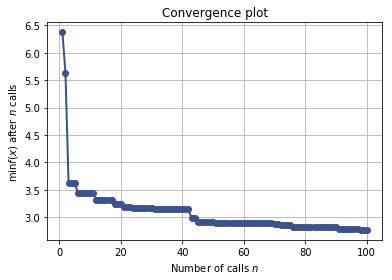

In [15]:
plt.show()

In [ ]:
def objective(params):
    pass
space = [
    (1, 5),
]